<a href="https://colab.research.google.com/github/MogY23/HSE_project_credit_scoring_23/blob/main/Result_MY/Ver3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Решение задачи расчета кредитного скоринга

* Загрузка данных и их анализ
* Обучение и оценка качества модели
  + обучение модели
  + оценка качества модели
* Интерпретация результатов модели
* Сохранение результатов

Используем следующие библиотеки Python:

*   Pandas - библиотеки для работы с таблицами
*   Numpy - библиотеки для быстрых и эффективных вычислений
*   Matplotlib - для визуализации данных
*   Sklearn - библиотеки с основными инструментами ML


Задача состоит в том, чтобы по различным характеристикам клиентов спрогнозировать целевую переменную - имел клиент просрочку 90 и более дней или нет (и если имел, то банк не будет выдавать кредит этому клиенту, а иначе будет).

## <font color='green'>1. Загрузка данных и их первичный анализ</font>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression  #логистическая регрессия для задач бинарной классификации (уйдет/не уйдет)

import warnings
warnings.filterwarnings("ignore")

Подключаемся к БД и загружаем данные

In [2]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2023-05-30 12:51:26--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2023-05-30 12:51:27 (574 MB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



In [3]:
!sudo apt update && sudo apt install --yes python3 python3-pip && \ #загрузка вспомогательных ячеек для работы с БД (обновляем библиотеки)
!pip3 install psycopg2-binary

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `sudo apt update && sudo apt install --yes python3 python3-pip && \ #загрузка вспомогательных ячеек для работы с БД (обновляем библиотеки)'
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 16.0 MB/s eta 0:00:00


In [4]:
import psycopg2 #подключение к БД
#параметры для подключения прописаны в БД заранее
conn = psycopg2.connect("""  
    host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
    port=6432
    sslmode=verify-full
    dbname=db_clients
    user=mlhs_student
    password=mlhs_student
    target_session_attrs=read-write
""") 

In [5]:
query = "SELECT * from public.credit_scoring"

data = pd.read_sql_query(query, conn) #записываем из базы нужную таблицу к себе в объект data 

conn.close() #отключаемся от базы

Описание данных клиентов:
* Целевая переменная **SeriousDlqin2yrs**: Клиент имел просрочку 90 и более дней
* RevolvingUtilizationOfUnsecuredLines: Общий баланс средств (total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits). 
* age: Возраст заемщика 
* NumberOfTime30-59DaysPastDueNotWorse: Сколько раз за последние 2 года наблюдалась просрочка 30-59 дней. 
* DebtRatio: Ежемесячные расходы (платеж по долгам, алиментам, расходы на проживания) деленные на месячный доход. 
* MonthlyIncome: Ежемесячный доход. 
* NumberOfOpenCreditLinesAndLoans: Количество открытых кредитов (напрмер, автокредит или ипотека) и кредитных карт. 
* NumberOfTimes90DaysLate: Сколько раз наблюдалась просрочка (90 и более дней)
* NumberOfTime60-89DaysPastDueNotWorse: Сколько раз за последние 2 года заемщик задержал платеж на 60-89 дней.
* NumberOfDependents: Количество иждивенцев на попечении (супруги, дети и др). 
* RealEstateLoansOrLines: Закодированное количество кредиов (в том числе под залог жилья) - чем больше код буквы, тем больше кредитов 
* GroupAge: закодированная возрастная группа - чем больше код, тем больше возраст.




In [6]:
data=data.drop_duplicates() #сразу убираем дубликаты
data.head(20) # голова таблицы, первые 5 строчек по умолчанию или сколько нужно, если укажешь в скобках

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,RealEstateLoansOrLines,GroupAge
0,0,0.221813,43.0,0,0.527888,3280.0,7,0,0,2.0,A,c
1,0,0.602794,25.0,0,0.065868,333.0,2,0,0,0.0,A,b
2,1,0.025656,38.0,0,0.475841,3000.0,7,0,0,2.0,A,c
3,0,0.075427,32.0,0,0.085512,7916.0,6,0,0,0.0,A,b
4,0,0.046560,58.0,0,0.241622,2416.0,9,0,0,0.0,A,d
5,1,0.392248,50.0,0,1.595253,4676.0,14,0,0,1.0,B,d
6,0,0.034421,69.0,0,0.042383,2500.0,17,0,0,1.0,A,e
7,0,0.392995,58.0,2,0.436103,5500.0,15,0,0,0.0,A,d
8,1,0.695321,38.0,0,0.618575,7859.0,8,0,0,3.0,A,c
9,0,0.055950,53.0,0,0.052868,2666.0,7,0,0,0.0,A,d


RealEstateLoansOrLines - закодированное кол-во кредитов. Чем больше код буквы, тем больше кредитов. Тк показатель количественный, попробуем его перевести в числовой вид

In [7]:
data = data.replace('A', '1')
data = data.replace('B', '2')
data = data.replace('C', '3')
data = data.replace('D', '4')
data = data.replace('E', '5')
data['RealEstateLoansOrLines']=pd.to_numeric(data['RealEstateLoansOrLines']) #меняем тип столбца

Проверяем

In [ ]:
data.tail() #конец таблицы, последние 5 строчек по умолчанию или сколько нужно, если укажешь в скобках

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfDependents,RealEstateLoansOrLines,GroupAge
149995,0,0.977899,63.0,0,517.000000,5400.0,5,0.0,1,d
149996,0,0.025449,58.0,0,0.253855,15500.0,7,2.0,1,d
149997,0,0.058001,83.0,0,0.013997,5000.0,6,0.0,1,e
149998,0,0.071273,42.0,0,0.008638,6945.0,3,1.0,1,c
149999,0,1.026395,44.0,0,0.494819,5500.0,7,1.0,1,c


In [8]:
data.info() #детальная информация по данным

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149366 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      149366 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  149366 non-null  float64
 2   age                                   134633 non-null  float64
 3   NumberOfTime30-59DaysPastDueNotWorse  149366 non-null  int64  
 4   DebtRatio                             149366 non-null  float64
 5   MonthlyIncome                         120171 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       149366 non-null  int64  
 7   NumberOfTimes90DaysLate               149366 non-null  int64  
 8   NumberOfTime60-89DaysPastDueNotWorse  149366 non-null  int64  
 9   NumberOfDependents                    145542 non-null  float64
 10  RealEstateLoansOrLines                149366 non-null  int64  
 11  

11 признаков + целевая переменная

# Разведочный анализ данных

## 1. Оценка качества данных
Посмотрим, есть ли в данных пропущенные значения.

In [9]:
data.isna().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                     14733
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29195
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3824
RealEstateLoansOrLines                      0
GroupAge                                    0
dtype: int64

Не хватает данных по возрасту клиентов, ежемесячному доходу и кол-ву иждивенцев.

### Обработка пропущенных значений


  

*   NumberOfDependents - **числовой признак**. Количество иждивенцев на попечении (супруги, дети и др). 




In [10]:
data.NumberOfDependents.value_counts(dropna=False)

0.0     86370
1.0     26314
2.0     19522
3.0      9483
NaN      3824
4.0      2862
5.0       746
6.0       158
7.0        51
8.0        24
10.0        5
9.0         5
13.0        1
20.0        1
Name: NumberOfDependents, dtype: int64

Пропусков **2,6%**. Можно заполнить наиболее частым значением: 0.

In [11]:
data['NumberOfDependents'] = data['NumberOfDependents'].fillna(0) #строки с пропусками заполняем 0

 

*   Age - числовой признак. Возраст заемщика.Пропущено **9,86%** данных. Убираем, будем опираться на возрастные групп

In [12]:
data = data.drop(['age'], axis=1)


*   MonthlyIncome - **числовой признак**. Ежемесячный доход. Пропущено 19,82% данных. Визуализируем содержание столбца

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa02627d330>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa02627d870>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa02627d090>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa02627ddb0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa02627e050>],
 'means': []}

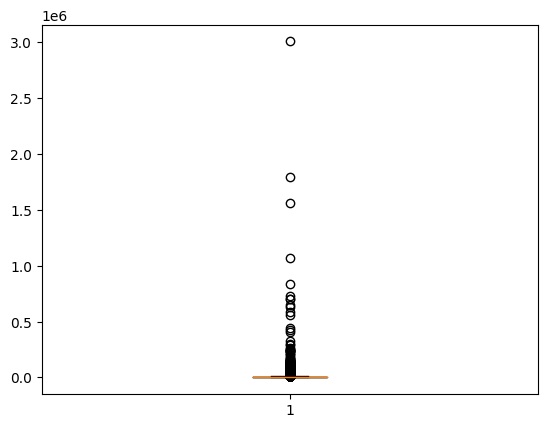

In [13]:
sr=data[data['MonthlyIncome']>0] #исключаем пустые, они помешают построить график
plt.boxplot(sr.MonthlyIncome)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa0261f1120>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa0261be410>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa0261f0e80>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa0261f1600>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa0261f18a0>],
 'means': []}

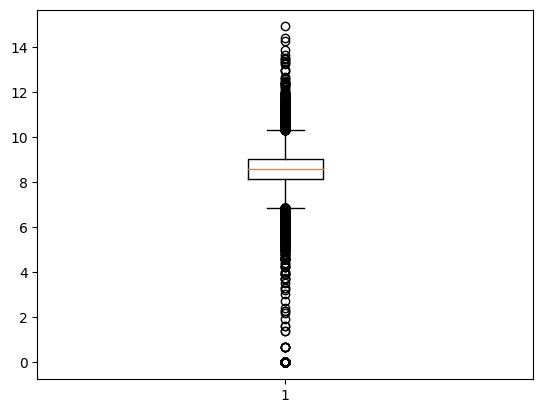

In [14]:
sr=data[data['MonthlyIncome']>0] #исключаем пустые, они помешают построить график
plt.boxplot(np.log(sr.MonthlyIncome))


Большинство данных лежат в пределах 1млн руб. Посчитаем медиану

In [15]:
median =  data['MonthlyIncome'].median()
print(median)

5400.0


Данным значением заполним пустые строки

In [16]:
data['MonthlyIncome'].fillna(median, inplace=True)

Проверяем все ли данные были исправлены

In [17]:
data.isna().sum()

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
RealEstateLoansOrLines                  0
GroupAge                                0
dtype: int64

## Сохранение данных

In [ ]:
data.to_csv("credit_scoring_output.csv", index=False) #сохраняем табличку к себе

## Основные числовые характеристики

Смотрим, что из себя представляют данные

In [19]:
data.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,RealEstateLoansOrLines
count,149366.00000,149366.000000,149366.000000,149366.000000,1.493660e+05,149366.000000,149366.000000,149366.000000,149366.000000,149366.000000
mean,0.06701,6.072049,0.395913,354.495057,6.425788e+03,8.481823,0.240075,0.214507,0.740530,1.077246
std,0.25004,250.284604,3.878021,2042.009339,1.291676e+04,5.136322,3.851472,3.835957,1.108326,0.306664
min,0.00000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.00000,0.030149,0.000000,0.177489,3.900000e+03,5.000000,0.000000,0.000000,0.000000,1.000000
50%,0.00000,0.154252,0.000000,0.368275,5.400000e+03,8.000000,0.000000,0.000000,0.000000,1.000000
75%,0.00000,0.556480,0.000000,0.875333,7.400000e+03,11.000000,0.000000,0.000000,1.000000,1.000000
max,1.00000,50708.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,98.000000,20.000000,5.000000


In [18]:
corr = data.corr() # строим матрицу корреляций

corr.style.background_gradient(cmap='coolwarm')

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,RealEstateLoansOrLines
SeriousDlqin2yrs,1.000000,-0.001819,0.131215,-0.007727,-0.017264,-0.030588,0.122239,0.106106,0.046506,0.027577
RevolvingUtilizationOfUnsecuredLines,-0.001819,1.000000,-0.001293,0.003945,0.006501,-0.011450,-0.001016,-0.001001,0.001131,-0.000900
NumberOfTime30-59DaysPastDueNotWorse,0.131215,-0.001293,1.000000,-0.005965,-0.008367,-0.049328,0.980744,0.984734,-0.000648,-0.003620
DebtRatio,-0.007727,0.003945,-0.005965,1.000000,-0.018107,0.048790,-0.007860,-0.007008,-0.045006,0.086314
MonthlyIncome,-0.017264,0.006501,-0.008367,-0.018107,1.000000,0.086531,-0.010660,-0.009308,0.066003,0.083959
NumberOfOpenCreditLinesAndLoans,-0.030588,-0.011450,-0.049328,0.048790,0.086531,1.000000,-0.075921,-0.066239,0.070630,0.262635
NumberOfTimes90DaysLate,0.122239,-0.001016,0.980744,-0.007860,-0.010660,-0.075921,1.000000,0.991525,-0.008495,-0.012334
NumberOfTime60-89DaysPastDueNotWorse,0.106106,-0.001001,0.984734,-0.007008,-0.009308,-0.066239,0.991525,1.000000,-0.009267,-0.010227
NumberOfDependents,0.046506,0.001131,-0.000648,-0.045006,0.066003,0.070630,-0.008495,-0.009267,1.000000,0.049024
RealEstateLoansOrLines,0.027577,-0.000900,-0.003620,0.086314,0.083959,0.262635,-0.012334,-0.010227,0.049024,1.000000


Очень большая корреляция между сроками просрочки. Необходимо удалить 2 лишних 

In [20]:
data = data.drop(['NumberOfTimes90DaysLate','NumberOfTime60-89DaysPastDueNotWorse'],axis=1)

In [21]:
for col in data.columns:
    try:
        print(col, np.corrcoef(data[col], data['SeriousDlqin2yrs'])[0][1])
    except:
        pass

SeriousDlqin2yrs 1.0
RevolvingUtilizationOfUnsecuredLines -0.0018192986071417195
NumberOfTime30-59DaysPastDueNotWorse 0.13121500401141908
DebtRatio -0.007726896864004403
MonthlyIncome -0.01726411065578203
NumberOfOpenCreditLinesAndLoans -0.030587755622646307
NumberOfDependents 0.04650641941765794
RealEstateLoansOrLines 0.027576898263311153


Логично, что больше всего с показателем просрочки 90+ коррелируют возраст клиента и наличие просрочек ранее.

## <font color='green'>2.1. Обучение модели</font>



Сформируем матрицу X объект-признак и вектор y целевой переменной.

In [22]:
X_full = data.drop('SeriousDlqin2yrs', axis=1) # матрица объект-признак
y = data['SeriousDlqin2yrs'] # целевая переменная

In [23]:
X = X_full.drop(['GroupAge'], axis=1)

Давайте применим логистическую регрессию для поиска клиентов с просрочками 90+

Данные разбиваем на train и test (test — 25% от всех данных).

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

Для линейных моделей очень важно масштабирование признаков. У нас часть данных представлена десятками, а часть тысячами и тд, это негативно влияет на модель. Для привидения к одному масштабу используем StandardScaler, обучив метод на тренировочных данных и применив его и к трейну, и к тесту.

In [25]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(Xtrain)

Xtrain = pd.DataFrame(ss.transform(Xtrain), columns=X.columns)
Xtest = pd.DataFrame(ss.transform(Xtest), columns=X.columns)

Xtrain.head()

,RevolvingUtilizationOfUnsecuredLines,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfDependents,RealEstateLoansOrLines
0,-0.020226,-0.101742,-0.158580,-0.101718,-0.678116,1.139480,-0.252764
1,-0.025334,-0.101742,-0.158434,-0.292379,-0.873086,-0.666918,-0.252764
2,-0.024850,-0.101742,-0.158422,-0.163436,1.271585,2.042678,-0.252764
3,-0.025293,-0.101742,-0.158567,-0.200580,-0.483145,-0.666918,-0.252764
4,-0.025031,-0.101742,-0.158225,-0.372880,3.416256,-0.666918,-0.252764


Обучим логистическую регрессию на train и сделаем предсказание на новых для нее данных (test).

In [26]:
from sklearn.linear_model import LogisticRegression # линейная модель для задачи классификации

model = LogisticRegression() # объявление модели

model.fit(Xtrain, ytrain) # обучение модели

LogisticRegression()

In [27]:
pred_test = model.predict(Xtest) # предсказание классов

In [28]:
accuracy_score(ytest, pred_test) #доля верных ответов на тестовой выборке

0.9333993894274544

Проверим, сбалансирована ли выборка.

In [29]:
y.value_counts()

0    139357
1     10009
Name: SeriousDlqin2yrs, dtype: int64

Баланса классов нет: большинство клиентов не имеют просрочек ($y=0$). Если я "в лоб" проставлю всем константу 0, то угадаю 138571 из 148552 (это как раз 93,3%).

## <font color='green'>2.2. Валидация модели</font>

Для оценки качества модели используются различные метрики качества. Построим матрицу ошибок
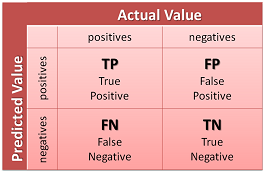


In [30]:
from sklearn.metrics import confusion_matrix

confusion_matrix(ytest, pred_test)

array([[34827,    19],
       [ 2468,    28]])



Также можно посмотреть на метрику **recall (полнота)** - она показывает, какую долю клиентов с просрочками 90+ дней (объектов положительного класса) определила модель.(TN/(FN+TN))</font>

In [31]:
from sklearn.metrics import recall_score

recall_score(ytest, pred_test)

0.011217948717948718

Пропустили 98,6% клиентов, которые с просрочками 90+ дней.

Посмотрим precision (**точность**) - показывает сколько клиентов, определенных, как "имеют просрочки 90+", действительно являются таковыми (TN/(FP+TN)

In [32]:
from sklearn.metrics import precision_score #точность. Из определенных, как "имеют просрочки 90+" сколько действительно имеют её(TN/(FP+TN)

precision_score(ytest, pred_test)

0.5957446808510638

С одной стороны recall очень мал, следовательно, мы выдадим много невозвратных кредитов. Но в данном случае нам гораздо важнее precision_score, тк банк зарабатывает на кредитах и любой ложный отказ это упущенная выгода, а просрочки Банк взымает в судебном порядке .


<font color='blue'>Попробуем изменить **порог для перевода вероятности в классы** со стандартного 0.5 </blue>

In [33]:
probs = model.predict_proba(Xtest)

probs[:10]

array([[0.93581217, 0.06418783],
       [0.93061339, 0.06938661],
       [0.93124707, 0.06875293],
       [0.93906215, 0.06093785],
       [0.94846468, 0.05153532],
       [0.93899111, 0.06100889],
       [0.94495631, 0.05504369],
       [0.93010155, 0.06989845],
       [0.95159392, 0.04840608],
       [0.96070622, 0.03929378]])

In [66]:
probs_arrears = probs[:,1]

classes = probs_arrears > 0.7 #по умолчанию 0,5 было

In [67]:
confusion_matrix(ytest, classes)

array([[34827,    19],
       [ 2468,    28]])

In [68]:
recall_score(ytest, classes)

0.011217948717948718

In [69]:
from sklearn.metrics import precision_score #точность. Из определенных, как "имеют просрочки 90+" сколько действительно имеют её(TN/(FP+TN)

precision_score(ytest, classes)

0.5957446808510638

Незначительный рост recall и precision.

## <font color='green'>3. Интерпретация модели</font>

После обучения модели можно посмотреть на её веса, то есть на коэффициенты при признаках, найденные моделью.

In [70]:
model.coef_, model.intercept_

(array([[-0.00496483,  0.18718483, -0.0848452 , -0.82284453, -0.11686562,
          0.20285908,  0.17996027]]),
 array([-2.70766059]))

In [71]:
import pandas as pd

coef_table = pd.DataFrame({'features' : list(X.columns), 'weights' : list(model.coef_[0])})

coef_table.sort_values(by='weights')

,features,weights
3,MonthlyIncome,-0.822845
4,NumberOfOpenCreditLinesAndLoans,-0.116866
2,DebtRatio,-0.084845
0,RevolvingUtilizationOfUnsecuredLines,-0.004965
6,RealEstateLoansOrLines,0.179960
1,NumberOfTime30-59DaysPastDueNotWorse,0.187185
5,NumberOfDependents,0.202859


Если вес у признака положительный, то признак вносит положительный вклад в ответ, то есть чем больше значение признака, тем больше это дает вклад в положительный класс объекта и наоборот.

*Пример:* 

чем **выше** ежемесячный доход, тем **меньше** вероятность просрочки 90+, 

но чем **больше** просрочек за 2 года, тем **больше** верочтность просрочки 90+

## <font color='green'>4. Сохранение результатов экспериментов</font>

Что сохраняем?

* Предсказания модели
* Эксперименты
* Модель

Сначала сохраним предсказания модели в файл:

In [72]:
Xtest['predictions'] = probs_arrears

Xtest[['predictions']].to_csv("PredictionsArrears.csv", index=False)

In [53]:
Xtest.head().T

,0,1,2,3,4
RevolvingUtilizationOfUnsecuredLines,-0.023249,-0.024253,-0.025293,-0.023682,-0.023561
NumberOfTime30-59DaysPastDueNotWorse,-0.101742,-0.101742,0.901891,-0.101742,0.149166
DebtRatio,-0.158078,-0.158465,-0.158243,-0.116069,-0.158236
MonthlyIncome,-0.052288,-0.042896,0.086612,-0.073472,0.233703
NumberOfOpenCreditLinesAndLoans,0.101765,-0.678116,0.101765,-0.873086,2.051466
NumberOfDependents,0.236281,0.236281,0.236281,-0.666918,1.139480
RealEstateLoansOrLines,-0.252764,-0.252764,-0.252764,-0.252764,-0.252764
predictions,0.064188,0.069387,0.068753,0.060938,0.051535


Теперь сохраним модель:

In [ ]:
import pickle 

with open('model.pickle', 'wb') as f:
    pickle.dump(model, f)

# а так модель можно загрузить из файла:  
# with open('filename.pickle', 'rb') as f:
#     model = pickle.load(f)

Сохраним полученную модель, файл с предсказаниями и ноутбук с экспериментами на гитхаб.

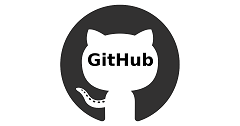

## <font color='green'>5. Градиентный бустинг</font>

Мы поработали с линейными моделями. Они весьма и весьма простые — предполагают независимость признаков и линейную связь между каждым признаком и целевой переменной. Конечно, в наших данных вряд ли всё так просто. Можно пытаться усложнять линейные модели: добавлять нелинейные признаки, переходить в новое признаковое пространство. Но это всё полумеры.

Сейчас мы поработаем с градиентным бустингом — одним из самых мощных подходов для работы с табличными данными.

Пока не ушли далеко — посчитаем и запомним качество логистической регрессии.

In [73]:
from sklearn import metrics

print("LR quality:")
print("precision: ", metrics.precision_score(ytest, classes))
print("recall: ", metrics.recall_score(ytest, classes))
print("auc-roc: ", metrics.roc_auc_score(ytest, probs[:, 1]))

LR quality:
precision:  0.5957446808510638
recall:  0.011217948717948718
auc-roc:  0.6349340313956501


Есть много имплементаций градиентного бустинга. Мы будем пользоваться CatBoost — библиотекой от Яндекса, которая очень эффективно написана и широко используется в мире.

In [75]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 10.6 MB/s eta 0:00:00


In [76]:
from catboost import CatBoostClassifier, Pool

In [77]:
Xtest = Xtest.drop(['predictions'],axis=1)

In [78]:
Xtrain.head().T

,0,1,2,3,4
RevolvingUtilizationOfUnsecuredLines,-0.020226,-0.025334,-0.024850,-0.025293,-0.025031
NumberOfTime30-59DaysPastDueNotWorse,-0.101742,-0.101742,-0.101742,-0.101742,-0.101742
DebtRatio,-0.158580,-0.158434,-0.158422,-0.158567,-0.158225
MonthlyIncome,-0.101718,-0.292379,-0.163436,-0.200580,-0.372880
NumberOfOpenCreditLinesAndLoans,-0.678116,-0.873086,1.271585,-0.483145,3.416256
NumberOfDependents,1.139480,-0.666918,2.042678,-0.666918,-0.666918
RealEstateLoansOrLines,-0.252764,-0.252764,-0.252764,-0.252764,-0.252764


In [79]:
train_set = Pool(Xtrain, ytrain)
test_set = Pool(Xtest, ytest)

In [95]:
gbm = CatBoostClassifier(iterations=900,#сколько деревьев строим
                          depth=2, #глубина 1го дерева
                          learning_rate=0.1,
                          loss_function='Logloss',
                          eval_metric='AUC',
                          verbose=False)
gbm.fit(train_set, eval_set=test_set)
gbm_preds = gbm.predict_proba(Xtest)

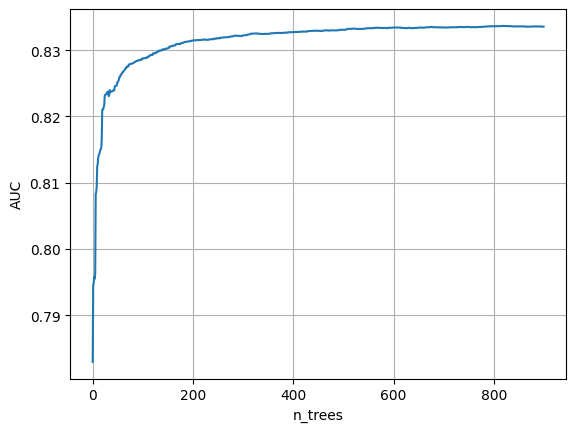

In [96]:
eval_metrics = gbm.get_evals_result()
plt.plot(eval_metrics['validation']['AUC'])
plt.xlabel('n_trees')
plt.ylabel('AUC')
plt.grid()

In [97]:
gbm_classes = (gbm_preds[:, 1] > 0.3)
print("precision: ", metrics.precision_score(ytest, gbm_classes))
print("recall: ", metrics.recall_score(ytest, gbm_classes))
print("auc-roc: ", metrics.roc_auc_score(ytest, gbm_preds[:, 1]))

precision:  0.42233632862644416
recall:  0.2636217948717949
auc-roc:  0.8336552971352338


In [98]:
coef_table = pd.DataFrame({'features' : list(X.columns), 'importances' : list(gbm.get_feature_importance())})

coef_table.sort_values(by='importances')

,features,importances
5,NumberOfDependents,1.291088
6,RealEstateLoansOrLines,1.734125
4,NumberOfOpenCreditLinesAndLoans,3.630363
3,MonthlyIncome,4.310783
2,DebtRatio,6.189481
1,NumberOfTime30-59DaysPastDueNotWorse,24.023287
0,RevolvingUtilizationOfUnsecuredLines,58.820873


## <font color='green'>6. Обработка категориальных признаков</font>

Выше мы удаляли все категориальные столбцы:

`X = X.drop(['GroupAge'], axis=1)`

А вдруг там содержится много полезной информации? Попробуем её сохранить.

In [99]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_full, y, test_size=0.25, random_state=42)

In [100]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical = ['GroupAge']
numeric_features = X.columns

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

X_transformed = column_transformer.fit_transform(Xtrain)
X_test_transformed = column_transformer.transform(Xtest)

In [101]:
X_transformed.shape

(112024, 12)

In [102]:
model = LogisticRegression()
model.fit(X_transformed, ytrain)
pred = model.predict_proba(X_test_transformed)

In [103]:
classes = (pred[:, 1] > 0.5)
print("precision: ", metrics.precision_score(ytest, classes))
print("recall: ", metrics.recall_score(ytest, classes))
print("auc-roc: ", metrics.roc_auc_score(ytest, pred[:, 1]))

precision:  0.5957446808510638
recall:  0.011217948717948718
auc-roc:  0.6556376962021171


In [104]:
train_set = Pool(X_transformed, ytrain)
test_set = Pool(X_test_transformed, ytest)
gbm = CatBoostClassifier(iterations=100,
                          depth=2,
                          learning_rate=0.1,
                          loss_function='Logloss',
                          eval_metric='AUC',
                          verbose=False)
gbm.fit(train_set, eval_set=test_set)
gbm_preds = gbm.predict_proba(test_set)
gbm_classes = (gbm_preds[:, 1] > 0.3)
print("precision: ", metrics.precision_score(ytest, gbm_classes))
print("recall: ", metrics.recall_score(ytest, gbm_classes))
print("auc-roc: ", metrics.roc_auc_score(ytest, gbm_preds[:, 1]))

precision:  0.43547224224945924
recall:  0.2419871794871795
auc-roc:  0.8293620018741804
